In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

In [3]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape

In [4]:
def show(img, height=height, width=width):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

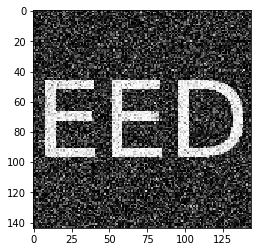

In [5]:
show(img)

In [6]:
def createBlurMask(sigma):
    maskSize = int(np.ceil(3.0*sigma))
    mask = np.zeros((maskSize*2+1, maskSize*2+1))
    
    maskSum = 0.0
    for a in xrange(-maskSize, maskSize+1):
        for b in xrange(-maskSize, maskSize+1):
            temp = np.exp(-( float(a*a + b*b) / (2*sigma*sigma) ))
            maskSum += temp
            mask[a+maskSize, b+maskSize] = temp
            
    # Normalize
    mask = mask / maskSum
    
    return mask, maskSize
    
    

<pyopencl.Context at 0x7fd8bf62c5d0 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
(144, 144)


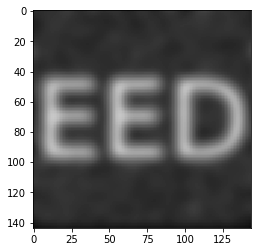

In [7]:
mask, maskSize = createBlurMask(4.0)

#ctx = cl.create_some_context()
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

img_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
blurred_img_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
mask_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask.astype(np.float32))

prg = cl.Program(ctx, """
__kernel void gaussian_blur(__global float * img_g, __constant float * mask, __private const int maskSize,
                            __global float * blurred_img_g)
{
  const int posx = get_global_id(0);
  const int posy = get_global_id(1);
  const int width = get_global_size(0);
  const int height = get_global_size(1);
  
  float sum = 0.0f;
  
  for (int a = -maskSize; a < maskSize+1; a++) {
    for (int b = -maskSize; b < maskSize+1; b++) {
      const int imgpos = clamp(posx+a, 0, width) + clamp(posy+b, 0, height)*width;
      sum += mask[a+maskSize + (b+maskSize)*(maskSize*2+1)] * img_g[imgpos];
    }
  }
  
  blurred_img_g[posx+posy*get_global_size(0)] = sum;
}


""").build()

kernel = prg.gaussian_blur
kernel.set_scalar_arg_dtypes( [None, None, np.int32, None] )
kernel(queue, img.shape, None, img_g, mask_g, maskSize, blurred_img_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, blurred_img_g)

# Show results
show(result_np)
print result_np.shape

In [8]:
cl.get_platforms()[0].get_devices()

[<pyopencl.Device 'Intel(R) Core(TM) i7-5557U CPU @ 3.10GHz' on 'Apple' at 0xffffffff>,
 <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>]

In [9]:
cl.get_supported_image_formats(ctx, cl.mem_flags.READ_ONLY, cl.mem_object_type.IMAGE2D)

[ImageFormat(RGBA, SNORM_INT8),
 ImageFormat(RGBA, SNORM_INT16),
 ImageFormat(RGBA, UNORM_INT8),
 ImageFormat(RGBA, UNORM_INT16),
 ImageFormat(RGBA, SIGNED_INT8),
 ImageFormat(RGBA, SIGNED_INT16),
 ImageFormat(RGBA, SIGNED_INT32),
 ImageFormat(RGBA, UNSIGNED_INT8),
 ImageFormat(RGBA, UNSIGNED_INT16),
 ImageFormat(RGBA, UNSIGNED_INT32),
 ImageFormat(RGBA, HALF_FLOAT),
 ImageFormat(RGBA, FLOAT),
 ImageFormat(BGRA, SNORM_INT8),
 ImageFormat(BGRA, SNORM_INT16),
 ImageFormat(BGRA, UNORM_INT8),
 ImageFormat(BGRA, UNORM_INT16),
 ImageFormat(BGRA, HALF_FLOAT),
 ImageFormat(BGRA, FLOAT),
 ImageFormat(<unknown channel order 0x10b7>, UNORM_INT8),
 ImageFormat(<unknown channel order 0x10000012>, UNORM_INT8),
 ImageFormat(R, SNORM_INT8),
 ImageFormat(R, SNORM_INT16),
 ImageFormat(R, UNORM_INT8),
 ImageFormat(R, UNORM_INT16),
 ImageFormat(R, SIGNED_INT8),
 ImageFormat(R, SIGNED_INT16),
 ImageFormat(R, SIGNED_INT32),
 ImageFormat(R, UNSIGNED_INT8),
 ImageFormat(R, UNSIGNED_INT16),
 ImageFormat(R, UNS

<pyopencl.Context at 0x7fd8bf654970 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>


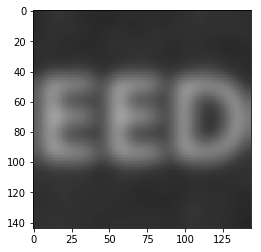

In [10]:
#linear homogeneous
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags

u_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
d_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

prg = cl.Program(ctx, """
__constant float dt = 0.1;

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

__kernel void linear_homogeneous(__global float * u_g,
                                 __global float * d_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    const int2 left_i  = reflect(pos + (int2)(-1,  0), height, width);
    const int2 right_i = reflect(pos + (int2)( 1,  0), height, width);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), height, width);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), height, width);

    const float left  = getpixel(u_g, left_i,  width);
    const float right = getpixel(u_g, right_i, width);
    const float up    = getpixel(u_g, up_i,    width);
    const float down  = getpixel(u_g, down_i,  width);

    d_g[pos.x + pos.y*width] = left + right + up + down - (4.0 * getpixel(u_g, pos, width));

    u_g[pos.x + pos.y*width] += d_g[pos.x + pos.y*width] * dt;
}


""").build()

kernel = prg.linear_homogeneous
for i in xrange(0,200):
    kernel(queue, img.shape, None, u_g, d_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)

# Show results
show(result_np)

<pyopencl.Context at 0x7fd8bf4a0260 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
CPU times: user 170 ms, sys: 33.2 ms, total: 203 ms
Wall time: 162 ms


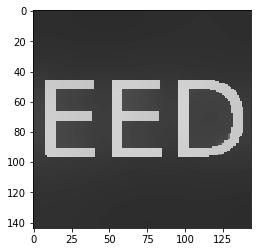

In [11]:
%%time
# nonlinear isotropic
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags
u = ndimage.gaussian_filter(img, sigma=1)

u_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=u.astype(np.float32))
d_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

prg = cl.Program(ctx, """
__constant float dt = 0.1;
//__constant float edge_threshold = 5.0; 
__constant float lsq = 25.0; //edge_threshold*edge_threshold;

inline float perona_malik_diffusivity(const float grad) {
    return 1.0/(1.0 + (grad*grad)/lsq);
}

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

__kernel void nonlinear_isotropic(__global float * u_g,
                                 __global float * d_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    const int2 left_i  = reflect(pos + (int2)(-1,  0), height, width);
    const int2 right_i = reflect(pos + (int2)( 1,  0), height, width);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), height, width);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), height, width);

    const float center  = getpixel(u_g, pos, width);
    const float d_left  = getpixel(u_g, left_i,  width) - center;
    const float d_right = getpixel(u_g, right_i, width) - center;
    const float d_up    = getpixel(u_g, up_i,    width) - center;
    const float d_down  = getpixel(u_g, down_i,  width) - center;
    
    const float g_left  = perona_malik_diffusivity(d_left);
    const float g_right = perona_malik_diffusivity(d_right);
    const float g_up    = perona_malik_diffusivity(d_up);
    const float g_down  = perona_malik_diffusivity(d_down);

    d_g[pos.x + pos.y*width] = g_left*d_left + g_right*d_right + g_up*d_up + g_down*d_down;

    u_g[pos.x + pos.y*width] += d_g[pos.x + pos.y*width] * dt;
}


""").build()

kernel = prg.nonlinear_isotropic
for i in xrange(0,10*200):
    kernel(queue, img.shape, None, u_g, d_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)

# Show results
show(result_np)

<pyopencl.Context at 0x7fd8bf5cfb20 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
1.25811e+06
CPU times: user 124 ms, sys: 32.1 ms, total: 156 ms
Wall time: 120 ms


/Users/jake/venvs/cl-tutorial/lib/python2.7/site-packages/ipykernel_launcher.py:224: DeprecationWarning: 'enqueue_copy_buffer' has been deprecated in version 2011.1. Please use enqueue_copy() instead.


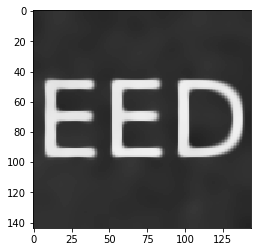

In [31]:
%%time
# EED with finite difference gaussian derivative presmoothing at each step

# Precompute gaussian derivative kernel for convolution on GPU  
def gaussian_derivative():
    #calculate sample points
    K = np.float32(3)
    x = np.arange(-K, K+1) # -K, -K+1, ..., 0, ..., K-1, K
    
    #sample gaussian and normalize (zero-order 1D kernel)
    Gs = np.exp( -x**2 / 2 )
    Gs = Gs / np.sum(Gs)
    
    # gaussian kernel
    gaussian_kernel = Gs
    
    # gaussian first derivative kernel
    gaussian_derivative_kernel = -x * Gs
    
    return gaussian_kernel, gaussian_derivative_kernel

gaussian_kernel, gaussian_derivative_kernel = gaussian_derivative()


# OpenCL stuff starts here
platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags


# Buffers for gaussian convolution
gaussian_kernel_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=gaussian_kernel.astype(np.float32))
gaussian_derivative_kernel_g = cl.Buffer(ctx, mf.READ_ONLY  | mf.COPY_HOST_PTR, hostbuf=gaussian_derivative_kernel.astype(np.float32))

tmp_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
Rx_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
Ry_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
Rw_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

# Buffers for diffusion
u_g = cl.Buffer(ctx, mf.READ_WRITE  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

# Diffusivity tensor components
a_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
b_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
c_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))

prg = cl.Program(ctx, """
__constant float dt = 0.1;
__constant float edge_threshold = 5.0; 
__constant float lsq = 25.0; //edge_threshold*edge_threshold;

inline float perona_malik_diffusivity(const float grad) {
    return 1.0/(1.0 + (grad*grad)/lsq);
}

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

__kernel void convolve_1d(__global float * u_g,
                          __global float * mask_g,
                          const int maskSize,
                          const int axis,
                          __global float * out_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    float sum = 0.0f;

    for (int a = -maskSize; a < maskSize+1; a++) {
        int2 shifted_pos;
        if (axis == 0) {
            shifted_pos = (int2)(pos.x  , pos.y+a);
        } else {
            shifted_pos = (int2)(pos.x+a, pos.y  );
        }
        const int2 rpos = reflect(shifted_pos, height, width);
        sum += mask_g[a+maskSize] * getpixel(u_g, rpos, width);
    }

    out_g[pos.x+pos.y*width] = sum;
}

__kernel void diffusivity_tensor(__global float * Rx_g,
                                 __global float * Ry_g,
                                 __global float * a_g,
                                 __global float * b_g,
                                 __global float * c_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    
    const float Rx = getpixel(Rx_g, pos, width);
    const float Ry = getpixel(Ry_g, pos, width);
    
    const float Rx2 = Rx*Rx;
    const float Ry2 = Ry*Ry;
    const float Rw2 = Rx2+Ry2;
    const float Rw = sqrt(Rw2);
    
    // eigenvalues for diffusion tensor
    const float c2 = 1.0/(1.0 + pown(Rw / edge_threshold, 2)); // Perona-Malik diffusivity across edges
    const float c1 = 1.0;                                      // full diffusion along edges
    
    // diffusion tensor components
    a_g[pos.x + pos.y*width] = (c1*Rx2 + c2*Ry2)   / (Rw2 + FLT_EPSILON);
    b_g[pos.x + pos.y*width] = (c2 - c1) * Rx * Ry / (Rw2 + FLT_EPSILON);
    c_g[pos.x + pos.y*width] = (c1*Ry2 + c2*Rx2)   / (Rw2 + FLT_EPSILON);
}

__kernel void eed(__global float * u_g,
                  __global float * a_g,
                  __global float * b_g,
                  __global float * c_g,
                  __global float * tmp_g)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);
    
    // all needed indices with reflected boundary conditions
    const int2 mc_i = reflect(pos + (int2)(-1,  0), height, width); //pad_u[i0-1, i1]
    const int2 pc_i = reflect(pos + (int2)(+1,  0), height, width); //pad_u[i0+1, i1]
    const int2 cm_i = reflect(pos + (int2)( 0, -1), height, width); //pad_u[i0  , i1-1]
    const int2 cp_i = reflect(pos + (int2)( 0, +1), height, width); //pad_u[i0  , i1+1]
    const int2 mm_i = reflect(pos + (int2)(-1, -1), height, width); //pad_u[i0-1, i1-1]
    const int2 pm_i = reflect(pos + (int2)(+1, -1), height, width); //pad_u[i0+1, i1-1]
    const int2 mp_i = reflect(pos + (int2)(-1, +1), height, width); //pad_u[i0-1, i1+1]
    const int2 pp_i = reflect(pos + (int2)(+1, +1), height, width); //pad_u[i0+1, i1+1]
    const int2 cc_i = pos;
    
    // pixels and neighbors
    const float umc = getpixel(u_g, mc_i, width);
    const float upc = getpixel(u_g, pc_i, width);
    const float ucm = getpixel(u_g, cm_i, width);
    const float ucp = getpixel(u_g, cp_i, width);
    const float umm = getpixel(u_g, mm_i, width);
    const float upm = getpixel(u_g, pm_i, width);
    const float ump = getpixel(u_g, mp_i, width);
    const float upp = getpixel(u_g, pp_i, width);
    const float ucc = getpixel(u_g, cc_i, width);
    
    // diffusion tensor components
    const float amc = getpixel(a_g, mc_i, width);
    const float apc = getpixel(a_g, pc_i, width);
    const float acc = getpixel(a_g, cc_i, width);

    const float bmc = getpixel(b_g, mc_i, width);
    const float bpc = getpixel(b_g, pc_i, width);
    const float bcm = getpixel(b_g, cm_i, width);
    const float bcp = getpixel(b_g, cp_i, width);
    const float bcc = getpixel(b_g, cc_i, width);
    
    const float ccp = getpixel(c_g, cp_i, width);
    const float ccm = getpixel(c_g, cm_i, width);
    const float ccc = getpixel(c_g, cc_i, width);

    const float d = (
        -0.25 * (bmc+bcp) * ump +
         0.5  * (ccp+ccc) * ucp +
         0.25 * (bpc+bcp) * upp +
         0.5  * (amc+acc) * umc -
         0.5  * (amc+2*acc+apc+ccm+2*ccc+ccp) * ucc +
         0.5  * (apc+acc) * upc +
         0.25 * (bmc+bcm) * umm +
         0.5  * (ccm+ccc) * ucm -
         0.25 * (bpc+bcm) * upm
    );

    tmp_g[pos.x + pos.y*width] = u_g[pos.x + pos.y*width] + d * dt;
}


""").build()

# Grab references to the kernels. When we do attribute access on prg, it creates an instance of each kernel.
# Because of this, we need to do `foo = prg.foo; foo.bar` and not just `prg.foo.bar`.
eed_kernel = prg.eed

convolve_1d_kernel = prg.convolve_1d
convolve_1d_kernel.set_scalar_arg_dtypes( [None, None, np.int32, np.int32, None] )

diffusivity_tensor_kernel = prg.diffusivity_tensor
VERTICAL = 1
HORIZONTAL = 0

for i in xrange(0,10*20):
    # Rx
    convolve_1d_kernel(queue, img.shape, None, u_g, gaussian_derivative_kernel_g, 3, HORIZONTAL, tmp_g)
    convolve_1d_kernel(queue, img.shape, None, tmp_g, gaussian_kernel_g, 3, VERTICAL, Rx_g)
    # Ry
    convolve_1d_kernel(queue, img.shape, None, u_g, gaussian_kernel_g, 3, HORIZONTAL, tmp_g)
    convolve_1d_kernel(queue, img.shape, None, tmp_g, gaussian_derivative_kernel_g, 3, VERTICAL, Ry_g)
    # a, b, c
    diffusivity_tensor_kernel(queue, img.shape, None, Rx_g, Ry_g, a_g, b_g, c_g)
    
    # EED step
    eed_kernel(queue, img.shape, None, u_g, a_g, b_g, c_g, tmp_g)
    # swap tmp buffer with image buffer in prep for next step
    cl.enqueue_copy_buffer(queue, tmp_g, u_g)
    # tmp_g, u_g = u_g, tmp_g
    
result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)
#cl.enqueue_copy(queue, result_np, Ry_g)

# Show results
print np.sum(result_np)
show(result_np)